In [2]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import os
import time
import math

from numpy import exp, sum
from scipy.optimize import differential_evolution

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [32]:
end = 20
DELTA = 0.01
n = int(end/DELTA)

lambda1 = 0.4
lambda2 = 2.0
#lambda3 = 4.0

beta1 = 15.0
beta2 = 4.0
beta3 = 0.5
beta = beta1 + beta2 + beta3

eta1 = 0.35
eta = 0.3
c=0.3
d = np.array((n+1)*[0.0])
d[0] = 1.0

dhat = np.array(n*[0.0])

B1 = np.array(n*[0.0])
B2 = np.array(n*[0.0])
B3 = np.array(n*[0.0])
B4 = np.array(n*[0.0])
B5 = np.array(n*[0.0])

B11 = np.array(n*[0.0])
B12 = np.array(n*[0.0])
B31 = np.array(n*[0.0])
B32 = np.array(n*[0.0])
B21 = np.array(n*[0.0])
B22 = np.array(n*[0.0])
B41 = np.array(n*[0.0])
B42 = np.array(n*[0.0])
B51 = np.array(n*[0.0])
B52 = np.array(n*[0.0])

In [33]:
def H(x): return (x>=0)*1

def FR1(a1,lambda1,x):
    return exp(-lambda1*x)*(H(x-a1)-1)+1

def FR12(a1,a2,x):
    return (-lambda2*(H(x-a1-a2)-H(x-a1))*exp(lambda2*(-x+a1)-lambda1*a1)+lambda1*(H(x-a1-a2)-H(x-a2))*exp(lambda1*(-x+a2)-lambda2*a2)+H(x-a2)*exp(-lambda2*x)*lambda1-H(x-a1)*exp(-lambda1*x)*lambda2 - exp(-lambda2*x)*lambda1 + exp(-lambda1*x)* lambda2 + lambda1-lambda2)/(lambda1-lambda2)

def ER12(a1,a2):
    return 1/lambda2+1/lambda1-1/(exp(lambda2*a2)*lambda2)-1/(exp(lambda1*a1)*lambda1)

def GR(a1,a2,x):
    return H(x)*(beta1*FR1(a1,lambda1,x) + beta2*FR1(a2,lambda2,x) + beta3*FR12(a1,a2,x))/beta

def EGR(a1,a2):
    return(beta1*ER12(a1,0) + beta2*ER12(0,a2) + beta3*ER12(a1,a2))/beta

def DGR(a1, a2, j):
    return GR(a1,a2,j*DELTA)-GR(a1,a2,(j-1)*DELTA)

def DGR1(a, j):
    return GR(a,a,j*DELTA)-GR(a,a,(j-1)*DELTA)

E1 = EGR(np.inf,np.inf)
def pR(a1,a2):
    return (1+eta)*beta*E1 - ((1+eta1)*beta*(E1-EGR(a1,a2)))
def pR1(a):
    return pR(a,a)

In [34]:
H    = numba.autojit(H,    nopython=True)
FR1  = numba.autojit(FR1,  nopython=True)
FR12 = numba.autojit(FR12, nopython=True)
ER12 = numba.autojit(ER12, nopython=True)
GR   = numba.autojit(GR,   nopython=True)
EGR  = numba.autojit(EGR,  nopython=True)
DGR  = numba.autojit(DGR,  nopython=True)
pR   = numba.autojit(pR,   nopython=True)
DGR1  = numba.autojit(DGR1,  nopython=True)
pR1   = numba.autojit(pR1,   nopython=True)

In [35]:
INF = 50.0
@numba.autojit(nopython = True) 
def Hinf(a,d,i):
    j1 = np.arange(i)
    j2 = np.arange(1,i+1)
    if a[0] < 0.0 : a[0]=0.0
   # if a[1] < 0.0 : a[1]=0.0
    a[0] = math.floor(a[0]/DELTA)*DELTA
   # a[1] = math.floor(a[1]/DELTA)*DELTA
    pRR = pR1(a[0])
    if pRR>0: return ((beta+c)*d[i]-0.5*beta*sum((d[i-j1]+d[i-j2])*DGR1(a[0], j2)))/pRR
    else : return  1000.0

@numba.autojit(nopython = True) 
def Hinf1(a,d,i):
    return Hinf([INF,a[0]],d,i)

@numba.autojit(nopython = True) 
def Hinf2(a,d,i):
    return Hinf([a[0],INF],d,i)

In [36]:
L11=L21=0.00001
U11=U21=60.0
L12=L22=90.000001
U12=U22=150.0
TIME=time.time()
for i in range(n):
    MIN1  = differential_evolution(Hinf ,args=(d,i),  bounds= [(L11, U11)])
    B1[i] = MIN1.x[0]
    #B2[i] = MIN1.x[1]
    if ( B1[i] < 20) : 
        L11 = np.maximum(0,B1[i] - 0.5)
        U11 = L11 + 1
       # L21 = np.maximum(0,B2[i] - 0.1)
       # U21 = L21 + 0.2
    #else :
      #  L11 = 0.0000001
      #  U11 = 90
       # L21 = 0.0000001
       # U21 = 90
    #MIN2   = differential_evolution(Hinf ,args=(d,i),  bounds= [(L12, U12), (L22,   U22)],tol=0.0005)
    #B12[i] = MIN2.x[0]
    #B22[i] = MIN2.x[1]
    #if (B12[i] > 0.00001) & (B12[i]> 80) : 
     #   L12 = np.maximum(0,B12[i] - 0.1)
      #  U12 = L12 + 0.4
    #if (B22[i] > 0.00001) & (B22[i]> 80) : 
     #   L22 = np.maximum(0,B22[i] - 0.1)
      #  U22 = L22+0.4
   # MIN1   = differential_evolution(Hinf1 ,args=(d,i),  bounds= [(L2, U2)],tol=0.0005)
   # MIN2   = differential_evolution(Hinf2 ,args=(d,i),  bounds= [(L1, U1)],tol=0.0005)
    
    #vals = np.array([MIN1.fun,MIN2.fun])
   # Ind = vals.argmin()
    
  #  if Ind==0:
       # B1[i] = MIN1.x[0]
       # B2[i] = MIN1.x[1]
    #if Ind==1:
        #B1[i] = MIN2.x[0]
        #B2[i] = MIN2.x[1]
   # if Ind==2:
     #   B1[i] = MIN.x[0]
     #   B2[i] = INF
    #if Ind==3:
      #  B1[i] = INF
      #  B2[i] = INF
    
    #if (B1[i] > 0.00001) & (B1[i]< 75) : 
        #L1 = np.maximum(0,B1[i] - 0.1)
       # U1 = L1 + 0.2
    #if (B2[i] > 0.00001) & (B2[i]< 75) : 
        #L2 = np.maximum(0,B2[i] - 0.1)
        #U2 = L2+0.2
        
    dhat[i] = MIN1.fun
    d[i+1]=d[i]+DELTA*dhat[i]
    
    if (i+1)%(n//20)==0: 
        print(str(round(100*(i+1)/n))+'%, ' + 'd('+str(round((i+1)*DELTA,2))+') = '+
                           str(d[i+1]) + ', time = '+str(round(time.time()-TIME,1))+' seconds')
    

5%, d(1.0) = 1.3309149349692266, time = 5.7 seconds
10%, d(2.0) = 1.6104903546180327, time = 6.2 seconds
15%, d(3.0) = 1.8445633097135954, time = 6.7 seconds
20%, d(4.0) = 2.0463512616280446, time = 7.4 seconds
25%, d(5.0) = 2.225372192096138, time = 8.1 seconds
30%, d(6.0) = 2.387629361683947, time = 8.9 seconds
35%, d(7.0) = 2.5372024317923167, time = 9.9 seconds
40%, d(8.0) = 2.676948709075248, time = 11.0 seconds
45%, d(9.0) = 2.8089471284255216, time = 12.1 seconds
50%, d(10.0) = 2.934762123558919, time = 13.5 seconds
55%, d(11.0) = 3.0556034035428503, time = 14.8 seconds
60%, d(12.0) = 3.1724296912730896, time = 16.3 seconds
65%, d(13.0) = 3.286017904864306, time = 17.8 seconds
70%, d(14.0) = 3.3970105456628663, time = 19.4 seconds
75%, d(15.0) = 3.505948701079505, time = 21.1 seconds
80%, d(16.0) = 3.6132955386695014, time = 22.9 seconds
85%, d(17.0) = 3.7194532822575948, time = 24.8 seconds
90%, d(18.0) = 3.824775638766138, time = 26.8 seconds
95%, d(19.0) = 3.929577009581985, 

In [37]:
delta = d/d[n]
deltahat = dhat/d[n]

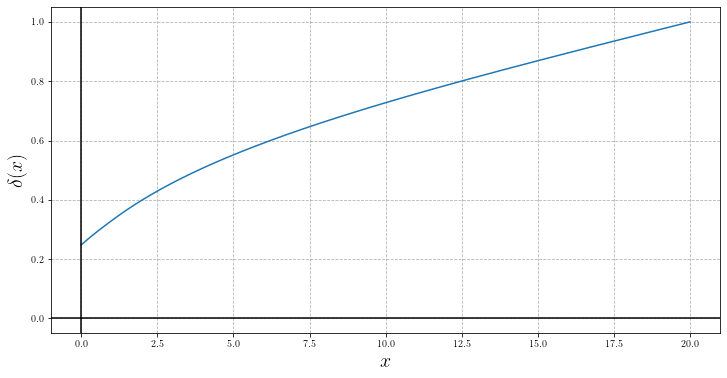

In [38]:
x = np.linspace(0,end,n+1)
plt.figure(figsize=(12,6))
plt.plot(x, delta)
plt.xlabel('$x$', fontsize=20)
plt.ylabel(r'$\delta(x)$', fontsize=20)
plt.axhline(y=0, color='k');plt.axvline(x=0, color='k')
plt.grid( color='0.7', linestyle='--')

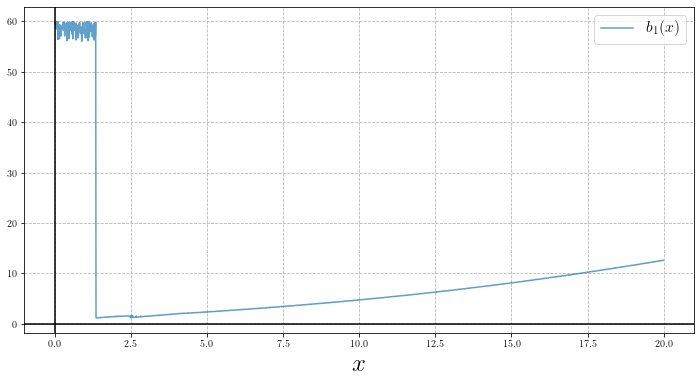

In [39]:
B1 = np.maximum(0,B1)
B2 = np.maximum(0,B2)

m = n
up = round(B1[n-1],1)
x = np.arange(m)*DELTA
plt.figure(figsize=(12,6))
plt.plot(x,B1[0:m],label='$b_1(x)$',alpha=0.7)
#plt.plot(x,B2[0:m],label='$b_2(x)$',alpha=0.7)
plt.xlabel('$x$', fontsize=25)
#plt.xlim((0,6))
plt.axhline(y=0, color='k');plt.axvline(x=0, color='k')
#plt.yticks([0,up,2*up,4*up],[0,up,2*up,r'$\infty$'],fontsize=16)
plt.grid( color='0.7', linestyle='--')
plt.legend(fontsize=16)
plt.show()

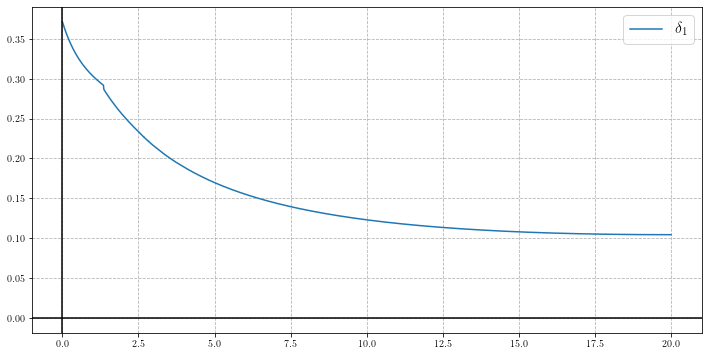

In [40]:
x = np.linspace(0,end,n)
plt.figure(figsize=(12,6))
#plt.xlim(0,2)
#plt.plot(x,delta1,label=r'$\delta$')
plt.plot(x,dhat,label=r'$\delta_1$')
plt.legend(fontsize=16)
plt.axhline(y=0, color='k');plt.axvline(x=0, color='k')
plt.grid( color='0.7', linestyle='--')
plt.show()

In [41]:
IndMin = np.argmin(dhat)

In [42]:
dhat[IndMin]

0.10452919244800249

In [43]:
IndMin*DELTA

19.92

In [44]:
x = np.linspace(0,end,n+1)
v = delta
vhat = deltahat
V = v/vhat[IndMin]
Vp = vhat/vhat[IndMin]

V[IndMin+1:] = V[IndMin] + np.arange(IndMin+1, n+1)*DELTA - (IndMin)*DELTA
Vp[IndMin+1:] = 1.0

In [45]:
V_coXLXL=V-x

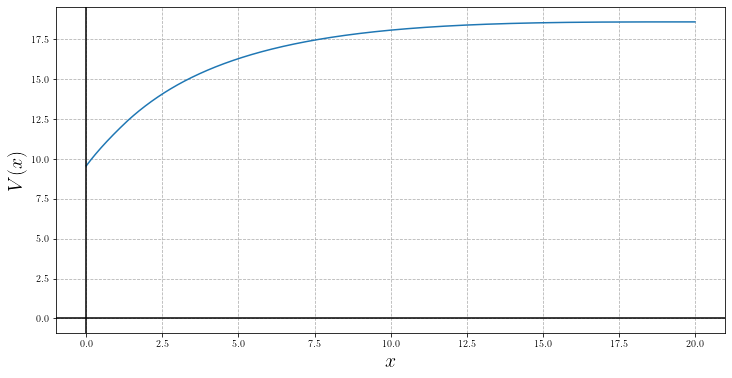

In [46]:
x = np.linspace(0,end,n+1)
plt.figure(figsize=(12,6))
plt.plot(x, V_coXLXL)
plt.xlabel('$x$', fontsize=20)
plt.ylabel(r'$V(x)$', fontsize=20)
#plt.xlim(0,5)
plt.axhline(y=0, color='k');plt.axvline(x=0, color='k')
plt.grid( color='0.7', linestyle='--')
plt.show()

In [48]:
import pandas as pd
IND = np.arange(0,n)
x = np.linspace(0,end,n+1)
DF = pd.DataFrame([x[IND],V_coXLXL[IND],B1[IND],B2[IND]],
                  index=['x','V','Line1','Line2']).T
DF.to_csv('oneXLcommon_20_0.01.csv')

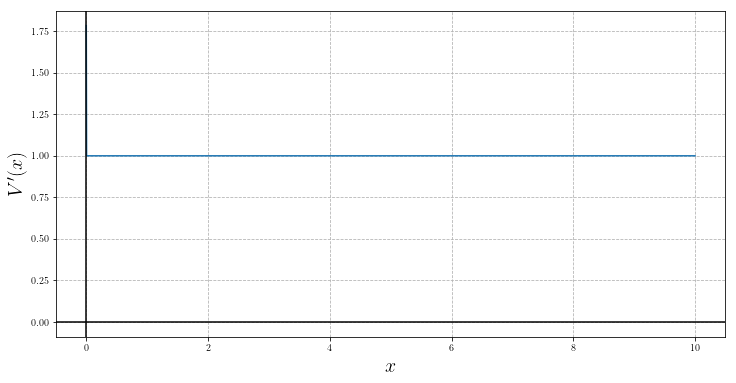

In [23]:
x = np.linspace(0,end,n)
plt.figure(figsize=(12,6))
plt.plot(x, Vp)
plt.xlabel('$x$', fontsize=20)
plt.ylabel(r"$V'(x)$", fontsize=20)
plt.axhline(y=0, color='k');plt.axvline(x=0, color='k')
plt.grid( color='0.7', linestyle='--')
plt.show()

In [37]:
supL = np.array(n*[0.0])
B1 = np.array(n*[0.0])
B2 = np.array(n*[0.0])
INF = 30.0
@numba.autojit(nopython = True) 
def nL(a,d,i):
    j = np.arange(i+1)
    if a[0] < 0.0 : a[0]=0.0
    if a[1] < 0.0 : a[1]=0.0
    a[0] = math.floor(a[0]/DELTA)*DELTA
    a[1] = math.floor(a[1]/DELTA)*DELTA
    pRR = pR(a[0],a[1])
    if pRR>0: return -(pRR*Vp[i]-(c+beta)*V[i] + beta*np.sum(V[i-j]*DGR(a[0],a[1],j)))
    else : return  1000.0

@numba.autojit(nopython = True) 
def nL1(a,d,i):
    return Hinf([INF,a[0]],d,i)

@numba.autojit(nopython = True) 
def nL2(a,d,i):
    return Hinf([a[0],INF],d,i)

In [39]:
L1=L2=-2.0
U1=U2=5.0

TIME=time.time()
for i in range(n):
    MIN   = differential_evolution(nL ,args=(d,i),  bounds= [(L1, U1), (L2,   U2)],tol=0.0005)
    MIN1   = differential_evolution(nL1 ,args=(d,i),  bounds= [(L2, U2)],tol=0.0005)
    MIN2   = differential_evolution(nL2 ,args=(d,i),  bounds= [(L1, U1)],tol=0.0005)
    
    vals = np.array([MIN.fun,MIN1.fun,MIN2.fun, Hinf([INF,INF],d,i)])
    Ind = vals.argmin()
    
    if Ind==0:
        B1[i] = MIN.x[0]
        B2[i] = MIN.x[1]
    if Ind==1:
        B1[i] = INF
        B2[i] = MIN1.x[0]
    if Ind==2:
        B1[i] = MIN.x[0]
        B2[i] = INF
    if Ind==3:
        B1[i] = INF
        B2[i] = INF
    supL[i] =  -np.min(vals)
    if (B1[i] > 0.00001) & (B1[i]< INF) : 
        L1 = np.maximum(0,B1[i] - 0.1)
        U1 = L1 + 0.2
    if (B2[i] > 0.00001) & (B2[i]< INF) : 
        L2 = np.maximum(0,B2[i] - 0.1)
        U2 = L2+0.2
        
    #dhat[i] = np.min(vals)
    #d[i+1]=d[i]+DELTA*dhat[i]
    
 
    if (i+1)%(n//20)==0: 
        print(str(round(100*(i+1)/n))+'%, ' + 'supL('+str(round((i+1)*DELTA,2))+') = '+str(supL[i]))

5%, supL(1.0) = -0.00378829555253013
10%, supL(2.0) = -0.005486571960947373
15%, supL(3.0) = -0.001993676782138465
20%, supL(4.0) = -0.1034280750979164
25%, supL(5.0) = -0.28977469711505677
30%, supL(6.0) = -0.4879112632227205
35%, supL(7.0) = -0.6876582920143051
40%, supL(8.0) = -0.8876240163562272
45%, supL(9.0) = -1.087619375523488
50%, supL(10.0) = -1.2876187473187883
55%, supL(11.0) = -1.4876186622875025
60%, supL(12.0) = -1.6876186507779067
65%, supL(13.0) = -1.8876186492199452
70%, supL(14.0) = -2.087618649008988
75%, supL(15.0) = -2.287618648980441
80%, supL(16.0) = -2.4876186489762517
85%, supL(17.0) = -2.687618648976013
90%, supL(18.0) = -2.887618648975945
95%, supL(19.0) = -3.087618648975706
100%, supL(20.0) = -3.287618648976178


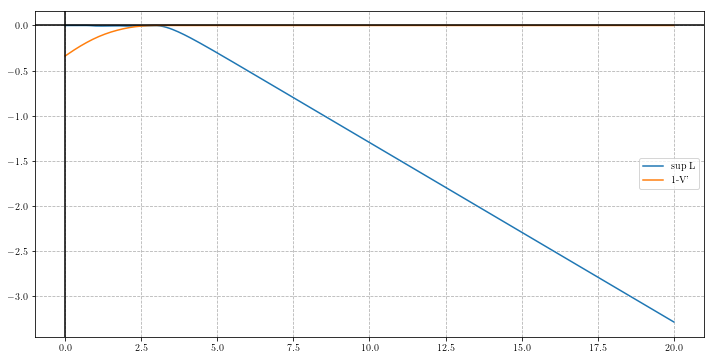

In [47]:
x = np.linspace(0,end,n)
plt.figure(figsize=(12,6))
plt.plot(x, supL, label = r"sup L")
plt.plot(x, 1-Vp, label = r"1-V'")
plt.axhline(y=0, color='k');plt.axvline(x=0, color='k')
plt.grid( color='0.7', linestyle='--')
plt.legend()
plt.show()

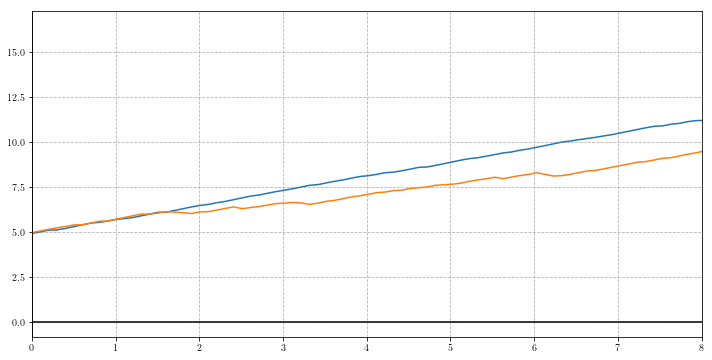

In [48]:
x = np.linspace(0,end,n)
plt.figure(figsize=(12,6))
plt.plot(x, B1)
plt.plot(x, B2)
#plt.plot(x, B3)
plt.xlim(0,8)
plt.axhline(y=0, color='k');plt.axvline(x=0, color='k')
plt.grid( color='0.7', linestyle='--')
plt.show()